# Use POCA Ellipsoid info to match Tracks to Primary Vertices
_____
The goal of this notebook is to attempt to match tracks to primary vertices using the mean and widths of the POCA error ellipsoids

___
<span style="color: blue;">First, let's check to see which GPUs are currently being used:</span>

In [1]:
!nvidia-smi

Thu Jun 10 11:07:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   40C    P8    24W / 250W |   7117MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   44C    P0    36W / 250W |   1531MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

___
<span style="color: blue;">Now, we can select which GPU we want to use:</span>

In [2]:
from model.training import select_gpu
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


___
<span style="color: blue;">Here, we import everything we need. The ellipsoid functions imported from model.plots_mdsA_200518 are originally from the Towards_Ellipsoids_*.ipynb notebooks. The model used in this notebook is the four-feature, 6-layer CNN.</span>

In [3]:
#import libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import numpy as np
import torch
import h5py
import math as m
try:
    import awkward0 as awkward
except ModuleNotFoundError:
    import awkward
concatenate = awkward.concatenate
from matplotlib.patches import Ellipse
import sys
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

#local imports
from model.models_mds_F import FourFeature_CNN6Layer_D as Model
from model.collectdata_poca_KDE import collect_data_poca, collect_truth
from model.plots_emk_200518 import gaussian, collect_poca, plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize

___
<span style="color: blue;">Now, we load our validation dataset, using the method imported from model.collectdata_poca_KDE. The validation set is created in slices of 500. Masking is set to True, and shuffle is set to False in order to retain the order of events. The device is set to that which we previously specified.</span>

In [4]:
#specify the path to the dataset (here, dataAA is a symlink to /share/lazy/sokoloff/ML-data_AA)
file = '/share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5'
validation = collect_data_poca(file,
                          batch_size=1,
                          slice=slice(500),
                          masking=True, shuffle=False,
                          device=device,
                          load_XandXsq=True,
                          load_xy=True)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.2446 s
Constructing 500 event dataset took 3.597 s


In [5]:
pocas = collect_poca(file)

<KeysViewHDF5 ['Xmax', 'Ymax', 'kernel', 'major_axis_x', 'major_axis_y', 'major_axis_z', 'minor_axis1_x', 'minor_axis1_y', 'minor_axis1_z', 'minor_axis2_x', 'minor_axis2_y', 'minor_axis2_z', 'poca_KDE_A', 'poca_KDE_A_xMax', 'poca_KDE_A_yMax', 'poca_KDE_B', 'poca_KDE_B_xMax', 'poca_KDE_B_yMax', 'poca_x', 'poca_y', 'poca_z', 'pv', 'pv_cat', 'pv_loc', 'pv_loc_x', 'pv_loc_y', 'pv_ntracks', 'pv_other', 'recon_tx', 'recon_ty', 'recon_x', 'recon_y', 'recon_z', 'sv', 'sv_cat', 'sv_loc', 'sv_loc_x', 'sv_loc_y', 'sv_ntracks', 'sv_other']>


___
<span style="color: blue;">Now we load the Xmax and Ymax arrays from the hdf5 file:</span>

In [6]:
with h5py.File(file, mode='r') as XY:
    #assign numpy arrays corresponding to xmax and ymax
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

___
<span style="color: blue;">Now we collect the truth information from the hdf5 file corresponding to the primary vertices (pvs = True) and print some examples.</span>

In [7]:
PV = collect_truth(file, pvs=True)
ind = 57
print('PV.n.shape =    ',  PV.n.shape)
print(f'PV.n[{ind}].shape = ', *PV.n[ind].shape)
print(f'PV.x[{ind}] =       ', *PV.x[ind])
print(f'PV.y[{ind}] =       ', *PV.y[ind])
print(f'PV.z[{ind}] =       ', *PV.z[ind])
print(f'PV.n[{ind}] =       ', *PV.n[ind])
print(f'PV.cat[{ind}] =     ', *PV.cat[ind])

Loaded /share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.01175 s
PV.n.shape =     (512,)
PV.n[57].shape =  10
PV.x[57] =        -0.0492 -0.0222 0.0252 -0.0338 0.0054 0.0093 -0.0277 -0.0129 -0.0187 -0.0326
PV.y[57] =        0.0044 0.0015 -0.0091 0.0336 -0.0147 -0.0057 -0.0016 -0.0099 0.0094 0.0293
PV.z[57] =        47.4726 -24.8486 -43.0271 -25.4903 -30.4667 12.7805 -52.4705 -39.3861 1.4138 -6.8486
PV.n[57] =        0 0 3 0 30 0 0 19 29 40
PV.cat[57] =      -1 -1 0 -1 1 -1 -1 1 1 1


___
<span style="color: blue;">We repeat the process for secondary vertices:</span>

In [8]:
SV = collect_truth(file, pvs=False)
ind = 57
print('SV.n.shape =    ', SV.n.shape)
print(f'SV.n[{ind}].shape = ', *SV.n[ind].shape)
print(f'SV.x[{ind}] =       ', *SV.x[ind])
print(f'SV.y[{ind}] =       ', *SV.y[ind])
print(f'SV.z[{ind}] =       ', *SV.z[ind])
print(f'SV.n[{ind}] =       ', *SV.n[ind])
print(f'SV.cat[{ind}] =     ', *SV.cat[ind])

Loaded /share/lazy/sokoloff/ML-data_AA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5 in 0.01301 s
SV.n.shape =     (512,)
SV.n[57].shape =  71
SV.x[57] =        0.0252 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 0.0054 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0129 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0187 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -0.0326 -14.9105 1.1078 11.7775 -0.0996 -12.4723 -12.523 3.6094 7.1751 9.7506 -6.3942 -10.021 -5.953 7.2533 -18.3299
SV.y[57] =        -0.0091 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0147 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 -0.0099 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0094 0.0

___
<span style="color: blue;">Now we need to load the model:</span>

In [9]:
#specify name of trained model
name = '/share/lazy/sokoloff/ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
model = Model().to(device)
d = torch.load(name)
d = modernize(d, 3)

#load and evaluate model
model.load_state_dict(d)
model.eval()

FourFeature_CNN6Layer_D(
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4of6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5of6): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (ppConv1): Conv1d(2, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (ppConv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (ppConv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (ppFc1): Linear(in_features=4000, out_features=4000, bias=True)
  (ppFinalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15)
  (conv2dropout): Dropout(p=0.15)
  (conv3dropout): Dropout(p=0.15)
  (conv4dropout): Dropout(p=0.15)
  (conv5dropout): Dropout(p=0.15)
)

___
<span style="color: blue;">Create numpy arrays corresponding to the outputs and labels of the model:</span>

In [10]:
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

___
<span style="color: blue;">Create numpy array corresponding to the test dataset:</span>

In [11]:
test = validation.dataset.tensors[0].cpu().numpy()
print('test.shape = ',test.shape)

test.shape =  (500, 4, 4000)


In [12]:
print(pocas.keys())

dict_keys(['x', 'y', 'z'])


___
<span style="color: blue;">Finally, we can create our plots:</span>


Event 0: Found 6 of 7, added 0 (eff 85.71%)


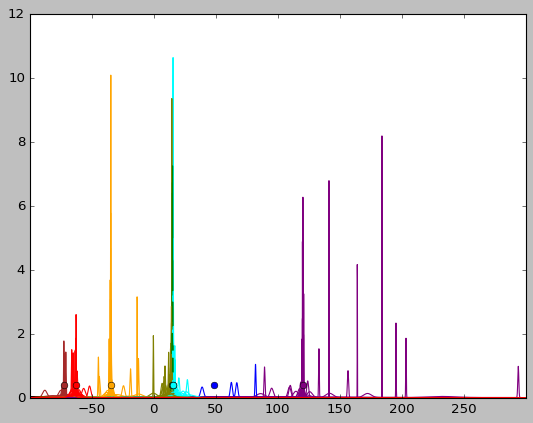

Event 0: Found 6 of 7, added 0 (eff 85.71%)



In [45]:
inputs = validation.dataset.tensors[0].cpu().numpy()[:,0,:]
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0
output_filename = None # Or set: '120000_3layer_{number:02}.pdf'

min_z_vals = []
max_z_vals = []

PV_colors = ['brown', 'red','orange','olive','green','cyan','blue','purple','pink']

# plot for 100 events
for event in range(2):
    
    #assign current input, label, and output for event
    input = inputs[event]
    label = labels[event]
    output = outputs[event]
    
    # Consistent parameters for the calls below
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    # Compute the "actual" efficencies and things
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    # Add a line to the final results string (print at end)
    finalmsg += f"Event {event}: {results}\n"
    
    # Make sure bin numbers are integers
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    # We plot over these "points of interest"
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    print(f"\nEvent {event}:", results)
    
    #sort PV z-position
    sortedPVs = sorted(PV.z[event])
    
    for j in range(len(pocas["z"]["poca"][event])):
        diff = np.abs(np.add(sortedPVs, -pocas["z"]["poca"][event][j]))
        ind = np.where(diff == diff.min())[0][0]
        current_gauss = gaussian(zvals, pocas["z"]["poca"][event][j], pocas["z"]["major_axis"][event][j])
        plt.plot(zvals, current_gauss, color = PV_colors[ind])
    
    #plt.plot(zvals, 7*input, color="g", label="Kernel Density", linewidth = 3)
    for j in range(len(sortedPVs)):
        plt.plot(sortedPVs[j], np.ones_like(sortedPVs[j])*.4, 'o', color= PV_colors[j], markeredgecolor = 'k')
    #plt.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='r')
    plt.xlim([zvals[0],zvals[-1]])
    plt.ylim([0,12])
    plt.show()
    break
    
    for index, i in enumerate(poi):
        # Convert to location in z
        center = (i / 10) - 100
        
        # Collect items less than 5 apart as "true"
        b_truth = np.fabs(ftruth - i) <= 5
        b_comp = np.fabs(fcomputed - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        elif False:
            pass # Check for NaNs
        else:
            msg = 'False positive'
            
        with plt.style.context({
            'font.size':18,
            'font.weight':'bold'}):
            
            #specify subplot information (3 subplots)
            fig, axs = plt.subplots(3, figsize=(12,16),
                                    gridspec_kw={'height_ratios':[2,1,1], 'hspace':0.3})
        
            #bins for plot_ruiplot (needed to find min/max for first axis)
            x_bins = np.round(zvals[i - 25 : i + 25] - 0.05, 2)
        
        
            ##############################
            #plot POCA z (second subplot)#
            ##############################
            
            #specify second axis for subplot
            ax_poca = axs[1]
            #calculate width of bins and subtract to make sure that our domain ends up correct
            width = x_bins[1]-x_bins[0]
            ax_poca.set_xlim([min(x_bins), max(x_bins)-width])
            
            #create array to plot POCA-ellipsoid Gaussians
            pocavals = np.arange(min(x_bins),max(x_bins)-(x_bins[1]-x_bins[0]),0.01)
            
            ax_poca.set_ylabel('POCA distribution (z)')
            #initialize sum of POCA gaussians (sum used in subplot 1)
            sum_poca = np.zeros(len(pocavals))
            #iterate through tracks, evaluate Gaussian over range pocavals, add to sum_poca, plot current poca-gaussian
            #note: Gaussians are scaled to unit area, width corresponds to the width of the major axis in the z-dir
            for j in range(len(pocas["z"]["poca"][event])):
                current_gauss = gaussian(pocavals, pocas["z"]["poca"][event][j], pocas["z"]["major_axis"][event][j])
                sum_poca = np.add(sum_poca, current_gauss)
                ax_poca.plot(pocavals, current_gauss, color = 'indigo')
        
        
            ####################################################
            #plot KDE, target, prediction, etc. (first subplot)#
            ####################################################
            
            # ax1 is the axis that is tied to left (density)
            # ax2 is the axis that is tied to the right (probability)
            # plot_ruiplot from plots_mdsA_200518 is the same as in plots_mdsA except ykernel is outputted in order to scale the poca sum
            ax1, ax2, ykernel = plot_ruiplot(zvals, i, input, label, output, ax=axs[0])
            ax1.set_title(f"Event {event} @ {center:.1f} mm: {msg}",
                          fontdict={'size':18, 'weight':'bold'})
            # calculate factor with which to scale the poca sum
            factor = max(ykernel)/max(sum_poca)
            # plot the sum of the gaussian poca-ellipsoids
            ax1.plot(pocavals, sum_poca*factor, color = 'g', label = "POCA sum")
            ax1.legend(loc = "upper left")
            ax1.set_xlim(ax_poca.get_xlim())

            msg = ""
            
            #display centroids of truth and prediction and their difference
            truth_centroid = (ftruth[b_truth] / 10) - 100
            for value in truth_centroid:
                msg += f"True: {value:.3f} mm\n"
                
            comp_centroid = (fcomputed[b_comp] / 10) - 100
            for value in comp_centroid:
                msg += f"Pred: {value:.3f} mm\n"
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = (comp_centroid[0] - truth_centroid[0]) * 1_000
                msg += f"∆: {diff:.0f} µm\n"
            
            ax1.text(.02, .8, msg,
                     transform=ax1.transAxes,
                     verticalalignment='top')
            
            print(f"\nEvent {event}.{index}:")
            
            # Plot PVs in blue (uncomment to print as well, but there may be a lot)
            ax2.scatter(PV.z[event], np.ones_like(PV.z[event])*.4, s=50, color='C0')
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                if center - 2.5 < z < center + 2.5:
                    #print()
                    print(f'PV: {n} tracks (type {cat})')
                    

            # Plot SVs in green (uncomment to print as well, but there may be a lot)
            ax2.scatter(SV.z[event], np.ones_like(SV.z[event])*.6, s=50, color='C1')
            
            
            ####################################
            #plot xmax and ymax (third subplot)#
            ####################################
            
            #specify 3rd axis
            ax = axs[2]
            #plot xmax and ymax
            ax.plot((np.arange(4000) / 10) - 100, xmax[event]*1000000, label="x", color = 'red')
            ax.plot((np.arange(4000) / 10) - 100, ymax[event]*1000000, label="y", color = 'rebeccapurple')
            #ensure x-axis aligns with the first plot
            ax.set_xlim(ax1.get_xlim())
            ax.set_ylim(-150,150)
            ax.grid(axis='y')
            ax.set_ylabel('xy maximum [μm]')
            ax.legend(loc='best')
            
            ax.set_xlabel(ax1.get_xlabel())
            ax1.set_xlabel("")
            
            
            # Save and show
            if output_filename:        
                plt.savefig(output_filename.format(number=internal_count))
            plt.show()
            
            internal_count += 1
            
print(finalmsg)